# A/B Tests, Privacy and Online Regression

*How to run experiments without storing individual data*

AB tests, a.k.a. randomized controlled trials, are widely recognized as the gold standard technique to compute the causal effect of a treatment (a drug, ad, product, ...) on an outcome of interest (a disease, firm revenue, customer satisfaction, ...). We randomly split a set of subjects (patients, users, customers, ...) into a treatment and a control group and give the treatment to the treatment group. This procedure ensures that ex-ante, the only expected difference between the two groups is caused by the treatment.

One potential **privacy issue** is that one needs to store data about many users for the whole duration of the experiment in order to estimate the effect of the treatment. This is not necessarily tr

⚠️ Some parts are algebra-intense, but you can skip them if you are only interested in the intuition.

## Credit Cards and Donations

Suppose, for example, that we were a fintech company. We are interested in experimenting whether giving promotional discounts to users encourages them to spend more. In order to estimate the causal effect of coupons on spending, we would like to run an A/B test or randomized controlled trial. 

We have one major problem: we cannot store user-level information for privacy reasons. 

First, let's have a look at the data. I import the data generating process `dgp_credit()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py) and some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py). I include code snippets from [Deepnote](https://deepnote.com), a Jupyter-like web-based collaborative notebook environment. For our purpose, Deepnote is very handy because it allows me not only to include code but also output, like data and tables.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_credit

I first generate the whole dataset in one-shot. We will then investigate how to perform the experimental analysis in case the data was arriving dynamically.

In [3]:
N = 100
df = dgp_credit.generate_data(N)
df.head()

,c,treated,balance,spend
0,1,0,117.22,2.14
1,1,1,29.97,29.97
2,1,0,53.45,10.07
3,1,0,188.84,2.88
4,1,1,130.00,43.29


We have information on 100 users, for whom we observe...

First, let's have a look 

In [24]:
model = smf.ols('spend ~ treated + balance', data=df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.2712,1.275,4.134,0.000,2.741,7.802
treated,1.8561,1.532,1.211,0.229,-1.185,4.898
balance,0.0341,0.020,1.702,0.092,-0.006,0.074


In order to understand how we can make linear regression one data point at the time, we first need a brief linear algebra recap.

First of all, let's define $y$ the dependent variable, `spend` in our case, and $X$ the explanatory variable, the `treated` indicator, the account `balance` and a constant.

In [26]:
def xy_from_df(df, r0, r1):
    return df.iloc[r0:r1,:3].to_numpy(), df.iloc[r0:r1,3].to_numpy()

The  estimator is given by
$$
\hat{\beta}_{OLS} = (X'X)^{-1}X'y
$$

In [6]:
from numpy.linalg import inv

X, Y = xy_from_df(df, 0, 100)
inv(X.T @ X) @ X.T @ Y

array([5.27115294, 1.85610826, 0.03410236])

We get indeed the same exact number as with the `smf.ols` command!

Can we compute $\beta$ one observation at the time?

The answer is yes! Assume we had $n$ observations and we just received the $n+1$th observation: the pair $(x_{n+1}, y_{n+1})$. In order to compute $\hat{\beta}_{n+1}$ we need to have stored only two objects in memory

- $\hat{\beta}_{n}$, the previous estimate of $\beta$
- $(X_n' X_n)^{-1}$, the previous value of $(X' X)^{-1}$

First of all, how do we update $(X' X)^{-1}$? 
$$
\begin{align*}
(X_{n+1}' X_{n+1})^{-1} = (X_n' X_n)^{-1} - \frac{(X_n' X_n)^{-1} x_{n+1} x_{n+1}' (X_n' X_n)^{-1}}{1 + x_{n+1}' (X_n' X_n)^{-1} x_{n+1}}
\end{align*}
$$

After having updated $(X' X)^{-1}$, we can update $\hat{\beta}$.
$$
\hat{\beta}_{n+1} = \hat{\beta}_{n} + (X_n' X_n)^{-1} x_{n} (y_n - x_n' \hat{\beta}_{n})
$$

Note that this procedure is not only privacy friendly but also **memory-friendly**. Our dataset is a $100 \times 4$ matrix while $(X' X)^{-1}$ is $3 \times 3$ matrix and $\beta$ is a $3 \times 1$ matrix. We are storing only 12 numbers instead of up to 400!

In [55]:
def update_xb(XiX, beta, x, y):
    XiX -= (XiX @ x.T @ x @ XiX) / (1 + x @ XiX @ x.T )
    beta += XiX @ x.T @ (y - x @ beta)
    return XiX, beta

We are now ready to estimate our OLS coefficient, one data point at the time. However, we cannot really start from the first observation, because we would be unable to invert the matrix $X'X$. We need at least $k+1$ observations, where $k$ is the number of variables in $X$. 

Let's use a warm start of 10 observations to be safe.

In [23]:
# Initialize XiX and beta from first 10 observations
x, y = xy_from_df(df, 0, 10)
XiX = inv(x.T @ x)
beta = XiX @ x.T @ y

# Update estimate live
for n in range(10, N):
    x, y = xy_from_df(df, n, n+1)
    XiX, beta = update_xb(XiX, beta, x, y)
    
# Print result
print(beta)

[5.27115294 1.85610826 0.03410236]


We got exactly the same coefficient! Nice!

How did we get there? We can plot the evolution of out estimate $\hat{\beta}$ as we accumulate data. The dynamic plotting function is a bit more cumbersome, but you can find it in [`src.figures`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/figures.py).

In [10]:
from src.figures import online_regression

online_regression(df, "fig/online_reg1.gif")

![](fig/online_reg1.gif)

As we can see, as the number of data points increases, the estimate seems to less and less volatile.

But is it really the case? As usual, we are not just interested in the point estimate of the effect of the `coupon` on spending, we would also like to understand how precise this estimate is.

## Inference

We have seen how to estimate the treatment effect "online": one observation at the time. Can we also compute the variance of the estimator in the same manner? 

First of all, let's review what the variance of the OLS estimator looks like. Under baseline assumptions, the variance of the OLS estimator is given by:
$$
\text{Var}(\hat{\beta}_{OLS}) = (X'X)^{-1} \hat{\sigma}^2
$$

where $\hat{\sigma}^2$ is the variance of the residuals $e = (y - X'\hat{\beta})$.

The regression table reports the standard errors of the coefficients, which are the squared elements on the diagonal of $\text{Var}(\hat{\beta})$.

In [11]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.2712,1.275,4.134,0.000,2.741,7.802
treated,1.8561,1.532,1.211,0.229,-1.185,4.898
balance,0.0341,0.020,1.702,0.092,-0.006,0.074


Let's check that we would obtain the same numbers using matrix algebra.

In [40]:
beta = inv(X.T @ X) @ X.T @ Y
np.sqrt(np.diag(inv(X.T @ X) * np.var(Y - X @ beta)))

array([1.25571838, 1.50928106, 0.01973147])

Indeed, we get exactly the same numbers! 

We already have a method to part of $\text{Var}(\hat{\beta}_{OLS}$ online: $(X'X)^{-1}$ update the matrix $(X'X)^{-1}$ online. How do we update $\hat{\sigma}^2$? This is the formula to update the sum of squared residuals $S$.
$$
S_{n+1} = S_{n} + \frac{(y_{n+1} - x_{n+1}\hat{\beta_n})}{1 + x_{n+1}' (X_n' X_n)^{-1} x_{n+1}}
$$

In [41]:
def update_xbs(XiX, beta, S, x, y):
    S += (y - x @ beta)**2 / (1 + x @ XiX @ x.T )
    XiX -= (XiX @ x.T @ x @ XiX) / (1 + x @ XiX @ x.T )
    beta += XiX @ x.T @ (y - x @ beta)
    return XiX, beta, S[0,0]

Note, the order here is very important!

In [47]:
# Inizialize XiX, beta, and sigma from the first 10 observations
x, y = xy_from_df(df, 0, 10)
XiX = inv(x.T @ x)
beta = XiX @ x.T @ y
S = np.sum((y - x @ beta)**2)

# Update XiX, beta, and sigma online
for n in range(10, N):
    x, y = xy_from_df(df, n, n+1)
    XiX, beta, S = update_xbs(XiX, beta, S, x, y)
    
# Print result
print(np.sqrt(np.diag(XiX * S / (N - 3))))

[1.27498884 1.53244274 0.02003428]


We indeed got the same result! Note that to get from the sum of squared residuals $S$ to the residuals variance $\hat{\sigma}^2$ we need to divide by the degrees of freedom: $n - k = 100 - 3$.

As before we have plotted the evolution of the estimate of the OLS coefficient over time, we can now augment that plot with a confidence band of +- one standard deviation.

In [48]:
online_regression(df, "fig/online_reg2.gif", ci=True)

![](fig/online_reg2.gif)

As we can see, the estimated variance of the OLS estimator indeed decreases as the sample size increases.

## Bootstrap

So far we have used the asymptotic assumptions behind the Central Limit Theorem to compute the standard errors of the estimator. However, we have a particularly small sample. We further check the empirical distribution of the model residuals.

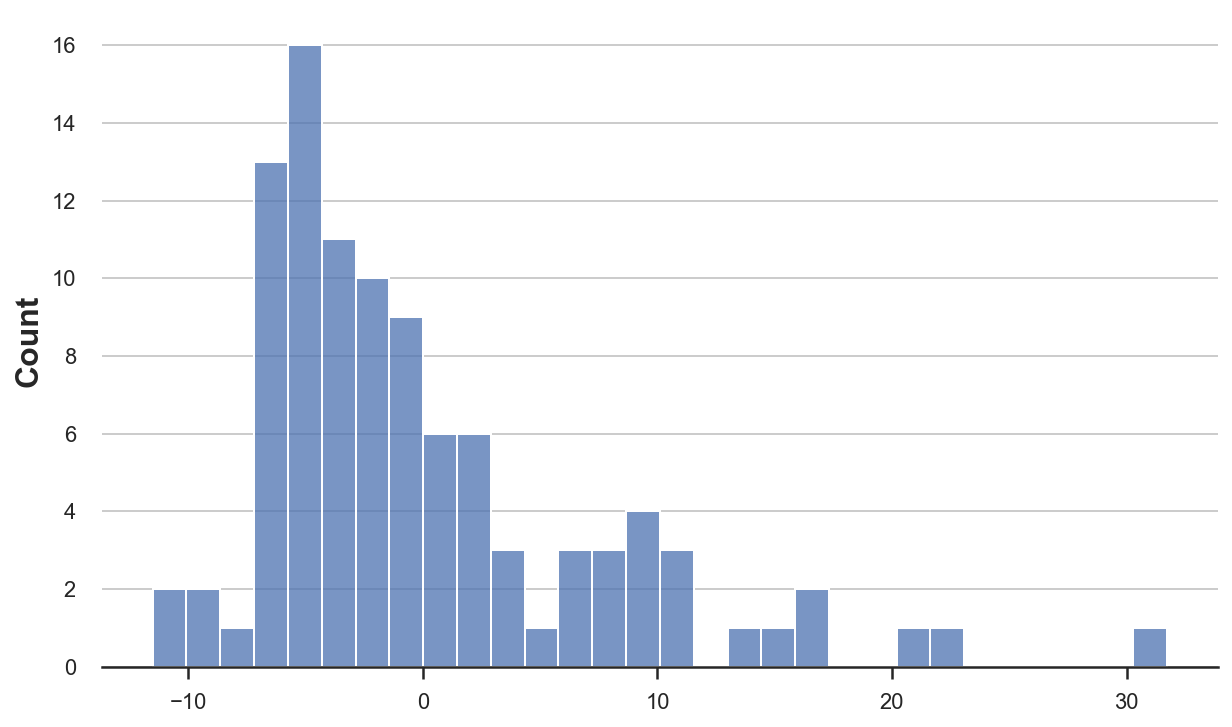

In [16]:
sns.histplot(model.resid, bins=30);

The residuals seem to be particularly **skewed**! This might be a problem in such a small sample. 

One alternative is **the bootstrap**. Instead of relying on asymptotics, we approximate the distribution of our estimator by resampling our dataset with replacement. Can we bootstrap online?

The answer is once again yes! They key is to weight each observation with an integer weight drawn from a Poisson distribution with mean (and variance) equal to 1. We repeat this process multiple times, in parallel and then we 

The updating rules for $(X'X)^{-1}$ and $\hat{beta}$ become the following.
$$
\begin{align*}
(X_{n+1}' X_{n+1})^{-1} = (X_n' X_n)^{-1} - \frac{w (X_n' X_n)^{-1} x_{n+1} x_{n+1}' (X_n' X_n)^{-1}}{1 + w x_{n+1}' (X_n' X_n)^{-1} x_{n+1}}
\end{align*}
$$

and
$$
\hat{\beta}_{n+1} = \hat{\beta}_{n} + w (X_n' X_n)^{-1} x_{n} (y_n - x_n' \hat{\beta}_{n})
$$

where $w$ are Poisson weights. First, let's update the updating function for $(X'X)^{-1}$ and $\hat{beta}$.

In [17]:
def update_xbw(XiX, beta, w, x, y):
    XiX -= (w * XiX @ x.T @ x @ XiX) / (1 + w * x @ XiX @ x.T )
    beta += w * XiX @ x.T @ (y - x @ beta)
    return XiX, beta

We can now run the online estimation. We bootstrap 1000 different estimates of $\hat{\beta}$.

In [51]:
# Inizialize a vector of XiXs and betas 
np.random.seed(0)
K = 1000
x, y = xy_from_df(df, 0, 10)
XiXs = [inv(x.T @ x) for k in range(K)]
betas = [xix @ x.T @ y for xix in XiXs]

# Update the vector of XiXs and betas online
for n in range(10, N):
    x, y = xy_from_df(df, n, n+1)
    for k in range(K):
        w = np.random.poisson(1)
        XiXs[k], betas[k] = update_xbw(XiXs[k], betas[k], w, x, y)

We can compute the estimated standard deviation of the treatment effect, simply by computing the standard deviation of the vector of bootstrapped coefficients.

In [52]:
np.std(betas, axis=0)

array([1.10757328, 1.27691523, 0.01923486])

The estimated standard errors are slightly different from the previous values of $[1.275, 1.532, 0.020]$, but not very far apart.

Lastly, some of you might have wondered "*why sampling discrete weights and not continuous ones?*". Indeed, we can. This procedure is called the **Bayesian Bootstrap** and you can find a more detailed explanation [here](https://towardsdatascience.com/6ca4a1d45148).

## Conclusion

In this post, we have seen hot to run an experiment without storing individual-level data. How are we able to do it? In order to compute the average treatment effect, we do not need every single observation but it's sufficient to store just a more compact representation of it. 

### References

[1] W. Chou, [Randomized Controlled Trials without Data Retention](https://arxiv.org/abs/2102.03316) (2021), *Working Paper*. 

### Related Articles

- [Experiments, Peeking, and Optimal Stopping](https://towardsdatascience.com/954506cec665)
- [The Bayesian Bootstrap](https://towardsdatascience.com/6ca4a1d45148)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/online_reg.ipynb